This iPython notebook is taken basically verbatim from the example in Chapter 2 of 'Probabilistic Programming and Bayesian Methods for Hackers' (open source, available at https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/).  The main author is Cam Davidson-Pilon

First, suppose there is one website, website A.  Let $p_{A}$ be the probability that users who see website A make a purchase.  This quantity is unknown, and may be different than the observed frequency.  Let's suppose we assign $p_{A}$ a uniform prior.  

In [65]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
# easy installation command if you have anaconda: conda install -c https://conda.binstar.org/pymc pymc
import pymc as pm

# The parameters are the bounds of the Uniform.
p = pm.Uniform('p', lower=0, upper=1)

Suppose $p_{A} = .05$ and $N = 1500$ users are shown website A.  We will simulate user purchases using $p_{A}$ (this is unknown, but we'll use it to simulate data for the purposes of illustration).    

In [66]:
# set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = pm.rbernoulli(p_true, N)

print occurrences  # Remember: Python treats True == 1, and False == 0
print occurrences.sum()

[False False False ..., False False False]
86


In [21]:
# Occurrences.mean is equal to n/N.
print "What is the observed frequency in Group A? %.4f" % occurrences.mean()
print "Does this equal the true frequency? %s" % (occurrences.mean() == p_true)

What is the observed frequency in Group A? 0.0513
Does this equal the true frequency? False


Let's plot the posterior distribution of $p_{A}$.  Don't worry about what the code is doing.

 [-----------------100%-----------------] 18000 of 18000 complete in 1.1 sec

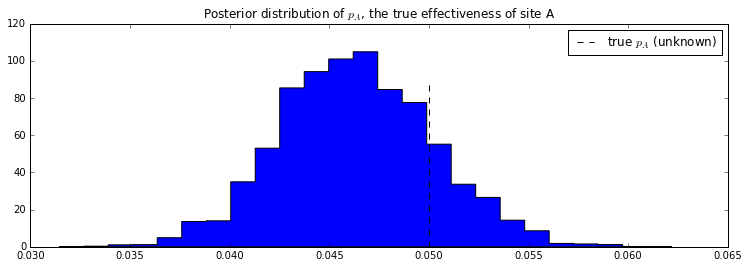

In [34]:
# include the observations, which are Bernoulli
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# To be explained in chapter 3
mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", normed=True)
plt.legend()

Now suppose there are two sites, A and B.  We will infer $p_{A}, p_{B},$ and $p_{A}-p_{B}$, the quantity of interest.

In [59]:
figsize(12, 4)

# these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

# notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 5000
N_B = 5000

# generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print "Obs from Site A: ", observations_A[:30].astype(int), "..."
print "Obs from Site B: ", observations_B[:30].astype(int), "..."

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [60]:
print observations_A.mean()
print observations_B.mean()

0.0522
0.0416


In [61]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the deterministic delta function. This is our unknown of interest.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets.
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# To be explained in chapter 3.
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.7 sec

In [62]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

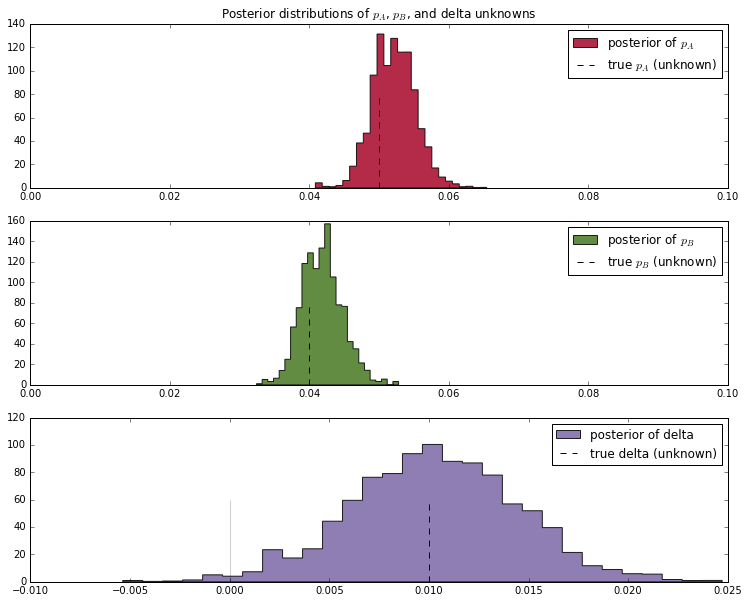

In [63]:
figsize(12.5, 10)

# histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [64]:

# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print "Probability site A is WORSE than site B: %.3f" % \
    (delta_samples < 0).mean()

print "Probability site A is BETTER than site B: %.3f" % \
    (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.010
Probability site A is BETTER than site B: 0.990


Note that since there are fewer observations for website B than for website A, the posterior distribution of $p_{B}$ is fatter than that of $p_{A}$ (we are less certain of the true value of $p_{B}$ than $p_{A}$).  Also, since most of the mass of the distribution of $p_{A} - p_{B}$ is to the right of $0$, we think that the purchase rate for site A is probably higher than for site B.

Try adjusting N_A and N_B and see how the results change.
